In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import datetime
from datetime import datetime
from sklearn import linear_model
import pickle
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import random
import seaborn as sns
import imblearn
from sklearn.metrics import precision_recall_curve

### Get HDD models

In [2]:
# Modules to get models from HDD data
def getModels(filepath):

    #print('reading hdf5')
    dfinal = pd.read_hdf(filepath)
    

    print("Current Time =", datetime.now().strftime("%H:%M:%S"))
    dfModels = dfinal['model'].drop_duplicates()
    
    return dfModels


def getAllModels(arr,yearArr,dfModelsFinal):
    for filename in arr:
        for year in yearArr:
            filepath = "~/data/"+filename+str(year)+".h5"
            
            dfmodels0 = pd.DataFrame(getModels(filepath))
            
            print(dfmodels0.columns)
            
            dfModelsFinal = pd.concat([dfModelsFinal,dfmodels0], axis = 0)
            
    return dfModelsFinal

In [3]:
# Create empty dataframe to store all availavle HDD models
column_names = ['model']
dfModelsFinal = pd.DataFrame(columns = column_names)

In [4]:
# Get models for 2019 year - Q1, Q2, Q3
arr = ['hdd_1_','hdd_2_','hdd_3_']
yearArr = [2019]
allmodels = getAllModels(arr,yearArr,dfModelsFinal)


Empty DataFrame
Columns: [model]
Index: []
Current Time = 01:30:38
Index(['model'], dtype='object')
Current Time = 01:31:20
Index(['model'], dtype='object')
Current Time = 01:32:04
Index(['model'], dtype='object')


In [5]:
allmodels = pd.DataFrame(allmodels['model'].drop_duplicates()).reset_index()
allmodels['modelType'] = allmodels.index

#save all models
allmodels[['model','modelType']].to_csv("~/data/allmodelsFile.csv")

In [6]:
def dataPreprocessing(filepath):

    print('reading hdf5')
    dfinal = pd.read_hdf(filepath)
    #dfinal = pd.read_pkl(filepath)

    print("Current Time =", datetime.now().strftime("%H:%M:%S"))
    dfSorted = dfinal.sort_values(by = ['date','model'])
    dfSorted['modelName'] = dfSorted['model']

    dfModels = dfinal['model'].drop_duplicates().reset_index()
    dfModels['modelType'] = dfModels.index

    dfSorted = pd.merge(left = dfSorted,right = dfModels, how='left', left_on='model',right_on = 'model')

    models = list(dfModels['model'])

    newModelsList=[]
    
    df_fail = dfSorted[dfSorted.failure==1]

    #filter out Models without any failure

    for item in models:
        df_model_fail = df_fail[df_fail.model==item]
        
        if len(df_model_fail)>0:
            newModelsList.append(item)

    print(newModelsList)


    df_updated = dfSorted[dfSorted['model'].isin(newModelsList)]

    print('done ')
    print("Current Time =", datetime.now().strftime("%H:%M:%S"))
    return df_updated

### Load historical data and smart features dictionary

In [7]:
print("Current Time =", datetime.now().strftime("%H:%M:%S"))
df_updated = dataPreprocessing("~/data/hdd_1_2019.h5")
dfModels = pd.read_csv("~/data/allmodelsFile.csv")
dffeatureDict = pd.read_csv("~/data/smartFeaturesDict.csv")

Current Time = 01:32:05
reading hdf5
Current Time = 01:32:13
['ST4000DM000', 'ST12000NM0007', 'HGST HMS5C4040ALE640', 'ST8000NM0055', 'ST8000DM002', 'HGST HMS5C4040BLE640', 'TOSHIBA MG07ACA14TA', 'HGST HUH721212ALN604', 'ST6000DX000', 'TOSHIBA MQ01ABF050', 'ST500LM030', 'ST10000NM0086', 'WDC WD60EFRX', 'TOSHIBA MQ01ABF050M', 'HGST HUH728080ALE600', 'WDC WD5000LPVX', 'ST500LM012 HN', 'WDC WD5000LPCX', 'ST8000DM004', 'HGST HUH721212ALE600']
done 
Current Time = 01:33:22


In [11]:
#adding another quarter of data
#df_updated1 = dataPreprocessing("~/data/hdd_2_2019.h5")
#df_updated = pd.concat([df_updated,df_updated1],axis = 0)
#df_updated['modelType1'] = df_updated['modelType']



### Get unique instances for HDD - all devices and failed drives

In [9]:
#unique serial numbers
df_serialNumbers = df_updated[['model','serial_number']].drop_duplicates()
df_serialNumbersFailes = df_updated[df_updated.failure==1][['model','serial_number']].drop_duplicates()
df_serialNumbersCnt = df_serialNumbers[['model','serial_number']].groupby(by = ['model']).count().rename(columns={'serial_number': 'count'})
df_serialNumbersCnt['model'] = df_serialNumbersCnt.index
df_serialNumbersFailesCnt = df_serialNumbersFailes[['model','serial_number']].groupby(by = ['model']).count().rename(columns={'serial_number': 'count'})
df_serialNumbersFailesCnt['model'] = df_serialNumbersFailesCnt.index
df_serialNumbersCnt['model_'] = df_serialNumbersCnt['model']
df_serialNumbersFailesCnt['model_'] = df_serialNumbersFailesCnt['model']

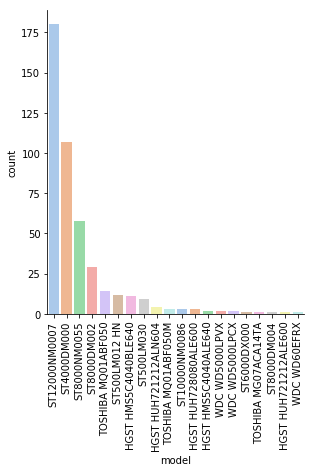

In [109]:
df_serialNumbersFailesCnt = df_serialNumbersFailesCnt.sort_values(by='count', ascending = False)
x = df_serialNumbersFailesCnt['model']
y = df_serialNumbersFailesCnt['count']
g = sns.catplot(x="model", y="count",kind = "bar", palette = "pastel",data=df_serialNumbersFailesCnt).set_titles('Failed devices')
g.set_xticklabels(rotation=90)
#g.set_titles('all devices')

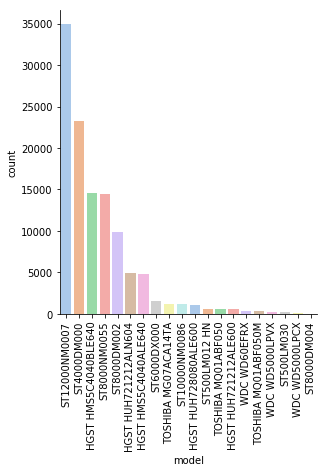

In [11]:
df_serialNumbersCnt = df_serialNumbersCnt.sort_values(by='count', ascending = False)
x = df_serialNumbersCnt['model']
y = df_serialNumbersCnt['count']
g = sns.catplot(x="model", y="count",kind = "bar", palette = "pastel",data=df_serialNumbersCnt).set_titles('all devices')
g.set_xticklabels(rotation=90)
#g.set_titles('all devices')

In [12]:
df_serialNumbersCntPrc=pd.merge(df_serialNumbersCnt,df_serialNumbersFailesCnt, how = 'left', right_on = 'model_',left_on = 'model_')
df_serialNumbersCntPrc['failurePrc'] = 100*(df_serialNumbersCntPrc.count_y/df_serialNumbersCntPrc.count_x)
df_serialNumbersCntPrc = df_serialNumbersCntPrc.sort_values(by = 'failurePrc', ascending = False).rename(columns = {'model_':'model'})





### Percentage of failed models

                   model  failurePrc
19           ST8000DM004   25.000000
17            ST500LM030    4.306220
18        WDC WD5000LPCX    3.571429
12    TOSHIBA MQ01ABF050    2.641509
11         ST500LM012 HN    1.967213
15   TOSHIBA MQ01ABF050M    0.789474
16        WDC WD5000LPVX    0.735294
0          ST12000NM0007    0.515685
1            ST4000DM000    0.460492
3           ST8000NM0055    0.401634
4            ST8000DM002    0.292693
10  HGST HUH728080ALE600    0.286260
14          WDC WD60EFRX    0.261780
9          ST10000NM0086    0.246305
13  HGST HUH721212ALE600    0.191939
5   HGST HUH721212ALN604    0.082034
8    TOSHIBA MG07ACA14TA    0.081566
2   HGST HMS5C4040BLE640    0.075560
7            ST6000DX000    0.065531
6   HGST HMS5C4040ALE640    0.041684


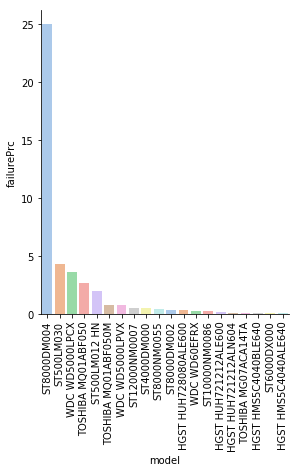

In [13]:
print(df_serialNumbersCntPrc[['model','failurePrc']])
x = df_serialNumbersCntPrc['model']
y = df_serialNumbersCntPrc['failurePrc']
g = sns.catplot(x="model", y="failurePrc",kind = "bar", palette = "pastel",data=df_serialNumbersCntPrc).set_titles('all devices')
g.set_xticklabels(rotation=90)

In [113]:
df_hdd = df_updated[pd.isnull(df_updated.smart_173_raw)]

In [114]:
df_ssd = df_updated[pd.notnull(df_updated.smart_173_raw)]

In [115]:
df_missing = pd.DataFrame(df_hdd.isnull().sum()).rename(columns = {0:'missingCnt'})

In [116]:
df_missingSorted = df_missing.sort_values(by = 'missingCnt', ascending=False)

In [117]:
df_missingSorted['missingPrc'] = df_missingSorted.missingCnt/(len(df_hdd))
df_missingSorted['col'] = df_missingSorted.index

### Feature selection - only features whth less than 25% of mnissing values

In [120]:
columns = df_missingSorted[df_missingSorted.missingPrc<=0.25].reset_index().sort_values(by = 'col')


In [121]:
lst = list(columns['col'])

uniqueCol = ['capacity_bytes']
for item in lst:
    if '_raw' in item:
        uniqueCol.append(item)

In [122]:
print(len(uniqueCol))
print(len(df_hdd), len(df_ssd))
print(len(df_ssd[df_ssd.failure==1]),len(df_hdd[df_hdd.failure==1]))

21
9537453 0
0 444


In [123]:
dfstat = df_hdd.describe()

In [26]:
def pickleToHdfConvert(filepathPkl,filepathHdf):
    df = pd.read_pickle(filepathPkl)
    df.to_hdf(filepathHdf, key='df', mode='w')

#pickleToHdfConvert("~/data/hdd_3_2019.pkl","~/data/hdd_3_2019.h5")

In [27]:
ds = df_hdd

### Resamling

In [28]:
# Resampling health devices
dfFailures = ds[ds.failure==1]
dfSuccess = ds[ds.failure==0].sample(n = 100000)
dfsample =  pd.concat([dfSuccess, dfFailures], axis=0)

In [29]:
dstrain = dfsample[dfsample.capacity_bytes>0]

print(len(dstrain[dstrain.failure==0]),len(dstrain[dstrain.failure==1]),len(dstrain) )



99992 444 100436


In [36]:
simpleFeaturesHist = ['capacity_bytes','modelType','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']
#simpleFeatures = ['capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']
smartFeatures = ['smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']
simpleFeatures_orig = ['capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']

simpleFeatures = uniqueCol




### Ploting

In [124]:
label = dstrain['failure']

Failure cases consist 0.4 percent of healthy ones


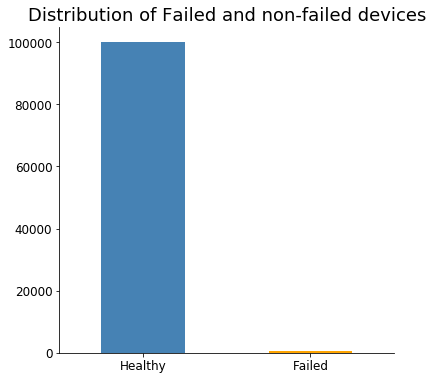

In [125]:
fig=plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    

label.value_counts().plot(kind='bar',
                        color = ['steelblue','orange'], fontsize=12)
#plt.gca().grid(linestyle='-.', linewidth='0.5',axis='y')
ax.set_title("Distribution of Failed and non-failed devices",fontsize=18)
#ax.set_yticks(np.arange(0,16001, 4000))
ax.set_xticklabels(['Healthy','Failed'], rotation=0,fontsize=12)
plt.savefig("classes")
print("Failure cases consist {0:.1f} percent of healthy ones".format(label.value_counts()[1]*100./label.value_counts()[0]))

In [41]:
def violin_plot(x,y,label):
    df = pd.concat([y,x],axis=1)
    df = pd.melt(df,id_vars=label,
                    var_name="features",
                    value_name='value')
    plt.figure(figsize=(12,8))
    sns.violinplot(x="features", y="value", hue=label, 
                   data=df,split=True, inner="quart")
    plt.xticks(rotation=60, fontsize=14)
    plt.ylabel("value", fontsize=18)
   # plt.gcf().subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.savefig('violin_plot')
    
    
    

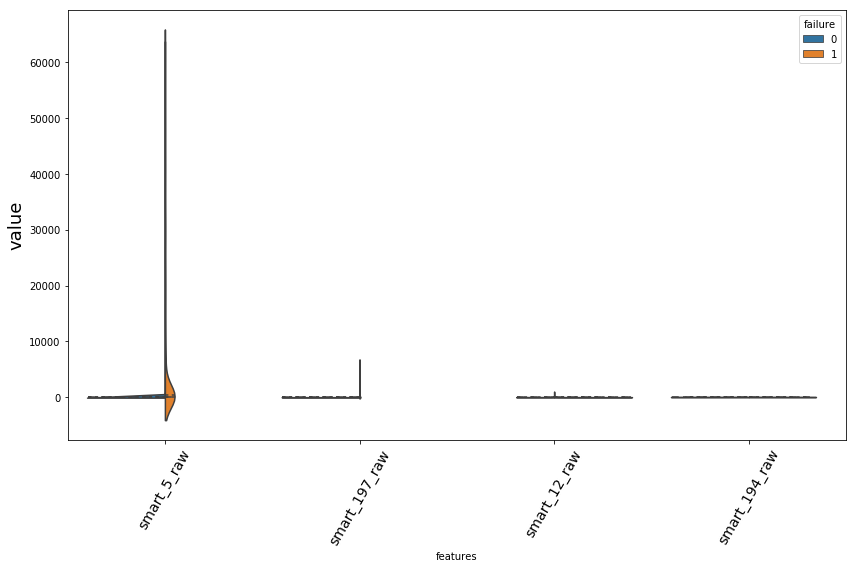

In [127]:
plotFeatures = ['smart_5_raw','smart_197_raw','smart_12_raw','smart_194_raw']
#, 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']

dstrain_plot = dstrain[plotFeatures]
violin_plot(dstrain_plot, label,"failure")

In [128]:
dstrain[simpleFeatures].describe()

,capacity_bytes,smart_10_raw,smart_12_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_199_raw,smart_1_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw
count,1.004360e+05,1.004350e+05,100435.000000,78075.000000,7.807500e+04,100435.000000,9.991000e+04,100435.000000,100435.000000,100435.000000,1.004350e+05,8.010000e+04,7.822400e+04,7.822400e+04,100435.000000,100435.000000,100435.000000,1.004350e+05,100435.000000
mean,7.842299e+12,3.001736e+01,5.754219,0.119513,1.259223e+08,167.846338,1.387968e+04,29.244815,0.331269,0.426624,9.536981e+07,9.422550e+11,4.417466e+10,9.928571e+10,195.881376,8.337601,18.277304,2.119177e+09,17082.094937
std,3.572573e+12,3.779193e+03,12.093552,6.390912,3.672833e+09,1077.063277,3.540582e+04,5.819350,27.069340,18.708506,8.046156e+07,1.321515e+13,1.364426e+10,2.343714e+11,990.321717,136.356279,637.863519,7.711797e+10,10250.053810
min,1.374390e+11,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,1.000000e+00,15.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.759000e+03,0.000000,1.000000,0.000000,0.000000e+00,0.000000
25%,4.000787e+12,0.000000e+00,2.000000,0.000000,0.000000e+00,1.000000,4.310000e+02,25.000000,0.000000,0.000000,8.248420e+06,8.695000e+03,4.090070e+10,7.625676e+10,0.000000,3.000000,0.000000,2.152630e+07,9576.000000
50%,8.001563e+12,0.000000e+00,4.000000,0.000000,0.000000e+00,20.000000,1.553000e+03,29.000000,0.000000,0.000000,8.780366e+07,1.358500e+04,4.678695e+10,1.028935e+11,0.000000,5.000000,0.000000,3.557790e+08,15718.000000
75%,1.200014e+13,0.000000e+00,7.000000,0.000000,0.000000e+00,130.000000,1.446700e+04,33.000000,0.000000,0.000000,1.680559e+08,2.587800e+04,5.298647e+10,1.229856e+11,0.000000,7.000000,0.000000,8.900841e+08,25350.000000
max,1.400052e+13,1.114112e+06,1008.000000,1723.000000,6.013057e+11,34192.000000,1.038700e+06,59.000000,6536.000000,4135.000000,2.441396e+08,2.801092e+14,1.832079e+11,3.237906e+13,9700.000000,25126.000000,63664.000000,1.093721e+13,49679.000000


In [129]:
def box_plot(x,y,label):
    df = pd.concat([y,x],axis=1)
    df = pd.melt(df,id_vars=label,
                    var_name="features",
                    value_name='value')
    plt.figure(figsize=(12,8))
    sns.boxplot(x="features", y="value", hue=label, 
                   data=df)
    plt.xticks(rotation=60, fontsize=14)
    plt.ylabel("value", fontsize=18)
    plt.tight_layout()
    plt.savefig('box_plot')

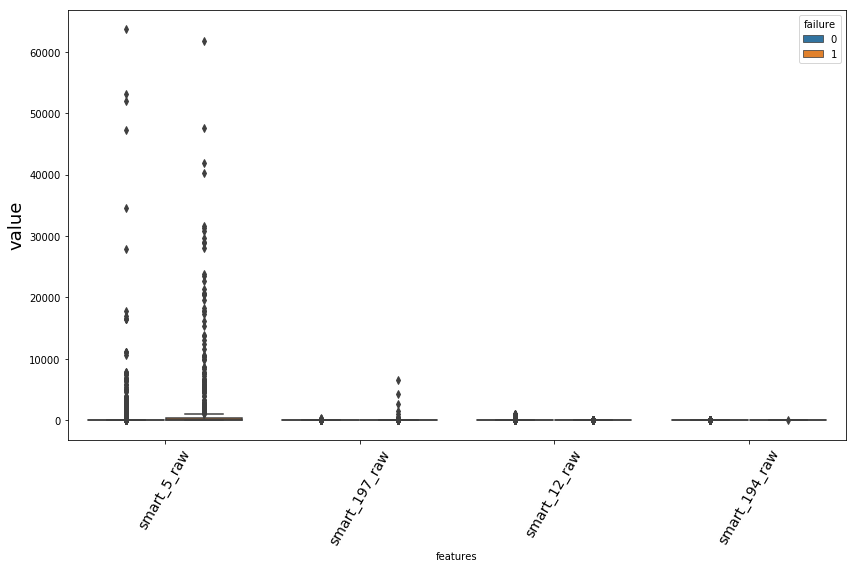

In [130]:
box_plot(dstrain[plotFeatures], label,"failure")

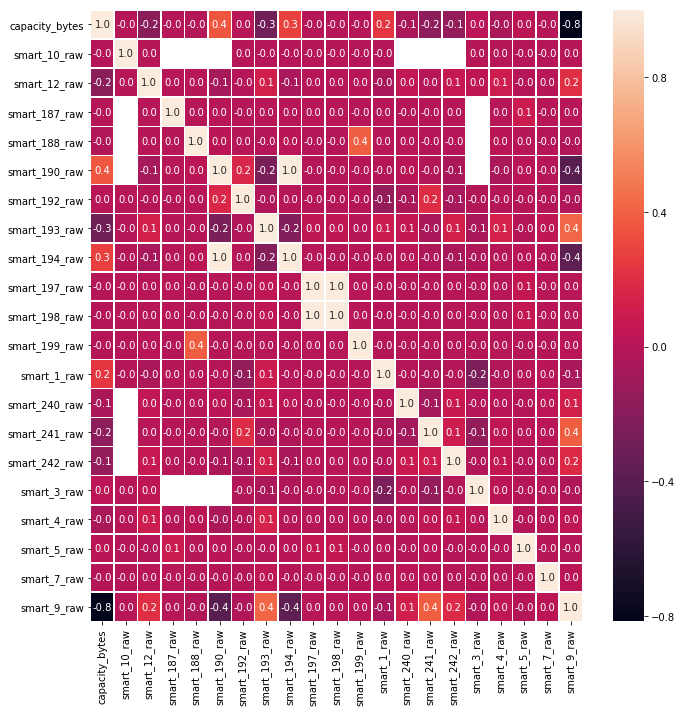

In [49]:
#correlation map
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dstrain[uniqueCol].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.tight_layout()
plt.savefig('heatmap')

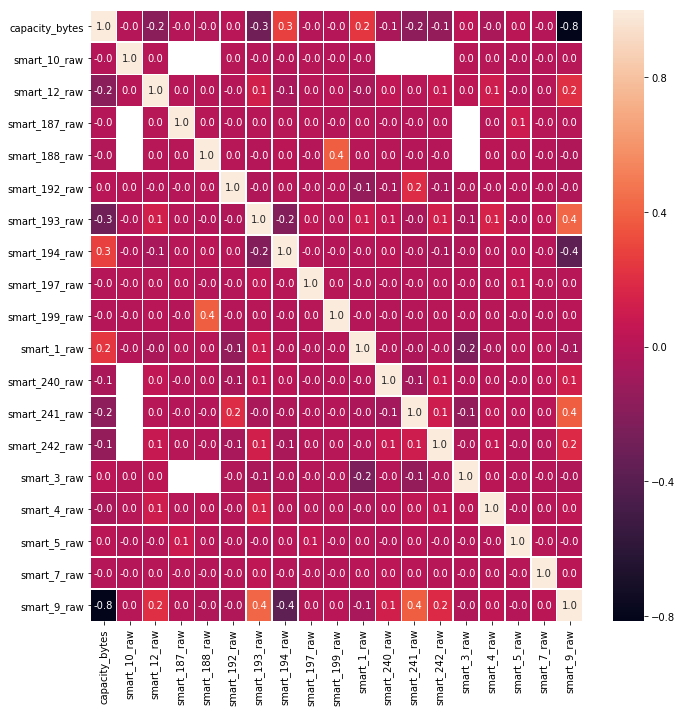

In [53]:
#exclude fetures which have high correlation: 190 and 198
simpleFeatures = ['capacity_bytes', 'smart_10_raw', 'smart_12_raw', 'smart_187_raw', 'smart_188_raw', 'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 'smart_197_raw',  'smart_199_raw', 'smart_1_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'smart_3_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw']

#correlation map after feqture exclusion
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dstrain[simpleFeatures].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.tight_layout()
plt.savefig('heatmap')

In [131]:
def dist_plot(df,feature, size_bin) :  
    failed = df.loc[df['failure']==1, feature]
    nonFailed = df.loc[df['failure']==0, feature]
    hist_data = [ nonFailed,failed]
    
    fig,ax = plt.subplots(figsize=(8, 6))
    ax = sns.distplot(failed, 
                     bins=size_bin,
                     label="Failed")
    ax = sns.distplot(nonFailed,
                    bins=size_bin,
                    label="Healthy")
    ax.set_title(feature, fontsize=18)
    sns.despine()
    plt.tight_layout()
    ax.set(xlabel='')
    plt.legend()
    plt.savefig(feature)

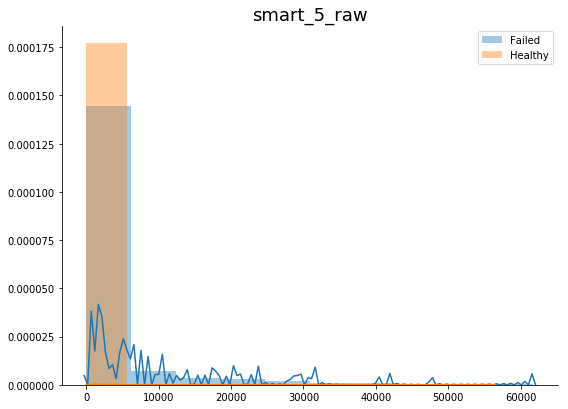

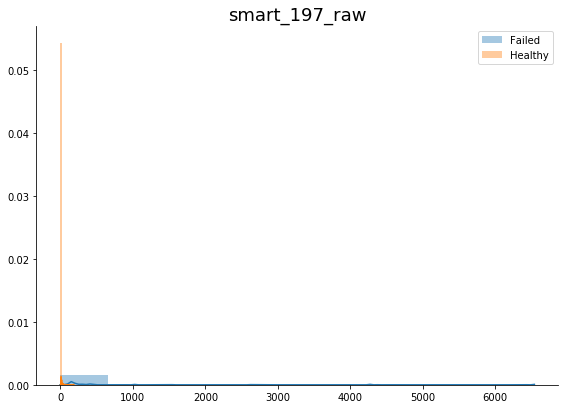

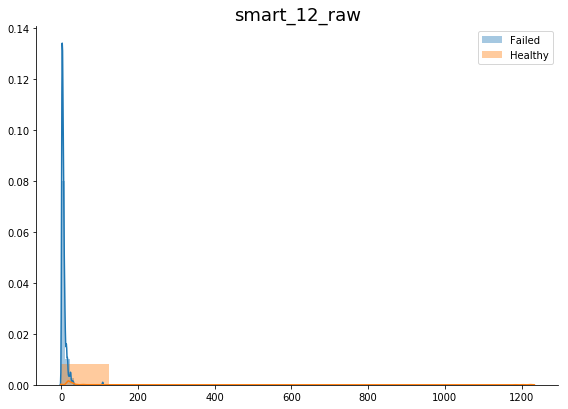

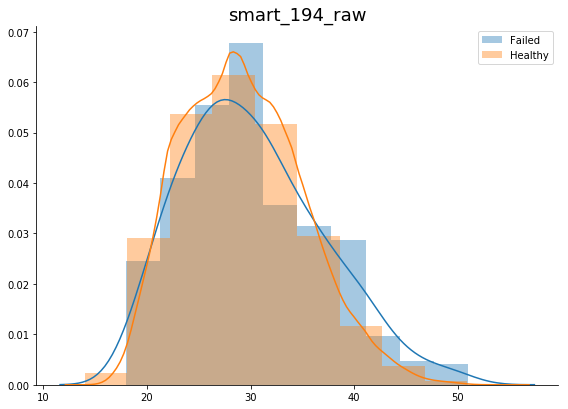

In [101]:
for col in plotFeatures:
    dist_plot(dstrain,col,10)

In [55]:
dfFailures = dstrain[dstrain.failure==1]
dfSuccess = dstrain[dstrain.failure==0]

In [56]:
dfFailStat = dfFailures.describe()
dfSuccessStat = dfSuccess.describe()

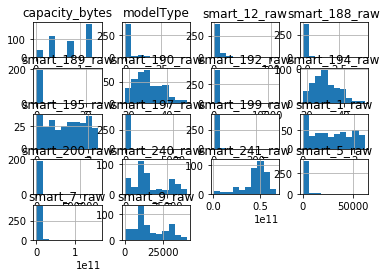

In [106]:
dfFailures[simpleFeaturesHist].hist()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74beeedda0>,
      dtype=object)

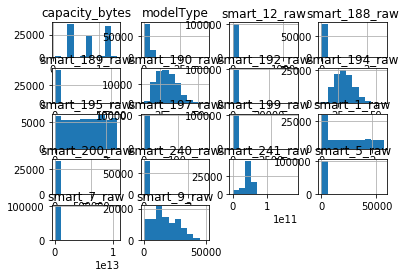

In [107]:
dfSuccess[simpleFeaturesHist].hist()

In [64]:

#for item in simpleFeaturesHist:
#    dfFailures[item].hist()
#    plt.title('Failure, '+ str(item))

    #dfSuccess[item].hist()
    #plt.title('NON - Failure, '+ str(item))
#    plt.show()
#counts, bins = np.histogram(dfFailures[['smart_194_raw']])
#plt.hist(bins[:-1], bins, weights=counts)
#plt.hist(dfFailures[['smart_194_raw']].dropna(), 50, density=True, facecolor='g', alpha=0.75)
#plt.show()

In [65]:
#for item in simpleFeaturesHist:
#   # dfFailures[item].hist()
    #plt.title('Failure, '+ str(item))

#    dfSuccess[item].hist()
#    plt.title('NON - Failure, '+ str(item))
#    plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74bf8d5160>]],
      dtype=object)

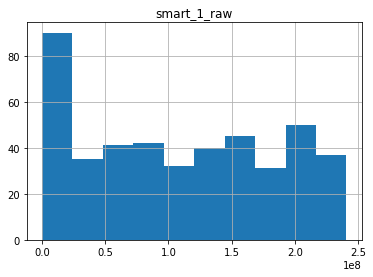

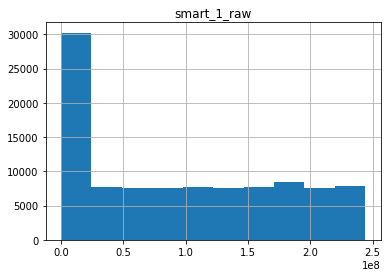

In [57]:
dfFailures[['smart_1_raw']].hist()
dfSuccess[['smart_1_raw']].hist()

In [67]:
#sm9_fail = dfFailures[['smart_9_raw']].hist()
#sm_9 = dfSuccess[['smart_9_raw']].hist()
#print(sm_9)
#plt.show()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


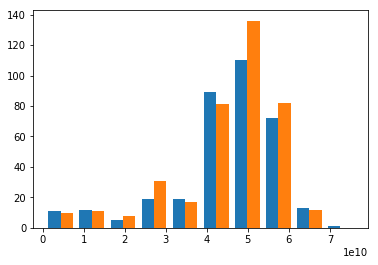

In [57]:
x=list(dfSuccess.sample(n=len(dfFailures)).smart_241_raw)
y=list(dfFailures.smart_241_raw)
plt.hist([x, y])
plt.show()
#sns.distplot([x, y])

In [70]:
#dfFailures[['smart_10_raw']].hist()
#dfSuccess[['smart_10_raw']].hist()

In [58]:
eda_fail = pd.DataFrame(dfFailures[simpleFeaturesHist].describe())
eda_success = pd.DataFrame(dfSuccess[simpleFeaturesHist].describe())

In [59]:
dfmean = pd.DataFrame(dfFailures[simpleFeatures].mean()).rename(columns={0: 'Fail'})
dfmean = pd.DataFrame(list(dfmean['Fail'])).rename(columns={0: 'Fail'})
dfmedian = dfFailures[simpleFeatures].median()

dfmeanSuccess = pd.DataFrame(dfSuccess[simpleFeatures].sample(n=600).mean()).rename(columns={0: 'nonFail'})
dfmeanSuccess = pd.DataFrame(list(dfmeanSuccess['nonFail'])).rename(columns={0: 'nonFail'})

dfcolumns = pd.DataFrame(simpleFeatures).rename(columns={0:'name'})




dfallMean = pd.merge(left = dfcolumns,right=dfmean, how = 'left', right_index=True,left_index=True)
dfallMean = pd.merge(left = dfallMean,right=dfmeanSuccess, how = 'left', right_index=True,left_index=True)
#print(dfallMean)

dfmeantest = dfallMean
dfmeanhours =  dfmeantest[dfmeantest.name =='smart_9_raw'] 
dfmeanNothours =  dfmeantest[dfmeantest.name !='smart_9_raw'] 

dfmeanhours['Fail'] = [x  for x in dfmeanhours['Fail']]
dfmeanhours['nonFail'] = [x  for x in dfmeanhours['nonFail']]

dfmeantest = pd.concat([dfmeanNothours,dfmeanhours], axis = 0)




print(dfmeantest)
dfallMean.to_csv("~/data/allmean.csv")

              name          Fail       nonFail
0   capacity_bytes  7.886056e+12  7.730751e+12
1     smart_10_raw  2.514926e+03  0.000000e+00
2     smart_12_raw  6.207675e+00  5.618333e+00
3    smart_187_raw  1.148837e+01  6.315789e-02
4    smart_188_raw  5.771134e+08  8.590085e+08
5    smart_192_raw  1.063905e+02  2.616333e+02
6    smart_193_raw  1.771082e+04  1.605880e+04
7    smart_194_raw  3.018736e+01  2.890167e+01
8    smart_197_raw  5.727540e+01  5.333333e-02
9    smart_199_raw  1.270880e+00  1.096667e+00
10     smart_1_raw  1.075678e+08  1.001515e+08
11   smart_240_raw  1.514161e+04  2.147153e+12
12   smart_241_raw  4.487619e+10  4.403003e+10
13   smart_242_raw  9.872776e+10  1.006893e+11
14     smart_3_raw  1.680519e+02  2.590850e+02
15     smart_4_raw  7.555305e+00  1.236000e+01
16     smart_5_raw  2.352260e+03  2.630000e+00
17     smart_7_raw  1.828387e+09  1.321089e+09
18     smart_9_raw  1.645013e+04  1.763460e+04


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
eda_fail.to_csv("~/data/eda_fail.csv")
eda_success.to_csv("~/data/eda_success.csv")

In [61]:
from imblearn.over_sampling import SMOTE

### Get training data - upsampling

In [62]:
Y = dstrain[['failure']]

X = dstrain[simpleFeatures]


X_train0 = X
y_train0 = Y

print("Number transactions X_train dataset: ", X_train0.shape)
print("Number transactions y_train dataset: ", y_train0.shape)


print("Current Time =", datetime.now().strftime("%H:%M:%S"))

X_train = X_train0.fillna(0)




print('Handling imbalanced data - starting SMOTE ...')


def overSamplingWithSMOTE(X_train,y_train0):
    sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

    #convert pandas to array
    y_train = np.array(y_train0.failure)

    #Create final training dataset
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    return X_train_res, y_train_res


X_train_res, y_train_res = overSamplingWithSMOTE(X_train,y_train0)

Number transactions X_train dataset:  (100436, 19)
Number transactions y_train dataset:  (100436, 1)
Current Time = 01:43:21
Handling imbalanced data - starting SMOTE ...


In [63]:
def readingTestDataset(filepath, dfModels, features):
    dsTest0 = pd.read_hdf(filepath)
    dsTest = dsTest0[dsTest0.capacity_bytes > 0]
    dsTest = pd.merge(left=dsTest, right=dfModels, how='left', left_on='model', right_on='model')
    
    #dsTest = dsTest[dsTest.model.isin(models)]
    # validate for another quarter
    
    #filtering out SSD
    dsTest = dsTest[pd.isnull(dsTest.smart_173_raw)]
    
    

    #filter out Models without any failure   
    
    Xtest = dsTest[features]
    Ytest = dsTest[['failure']]
    X1test = Xtest.fillna(0)

    return X1test, Ytest

In [64]:
def readingUserTestData(filepath, dfModels, features):
   
    
    ds = pd.read_csv(filepath).fillna(0)
    #dfModels = pd.read_csv(modelfile)

    dsTest = ds[ds.capacity_bytes > 0]
    dsTest = pd.merge(left=dsTest, right=dfModels, how='left', left_on='model', right_on='model')
    

    #simpleFeatures = ['capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw',
    #                  'smart_200_raw', 'smart_240_raw','smart_241_raw']

    simpleFeatures = features

    # validate for another quarter
    info = dsTest[['date','serial_number','model','capacity_bytes']]
    Xtest = dsTest[simpleFeatures]
    Ytest = dsTest[['failure']]
    X1test = Xtest.fillna(0)
    Ytest = dsTest[['failure']]

    #filtering out SSD
    #dsTest = dsTest[pd.isnull(dsTest.smart_173_raw)]
    
    

    #filter out Models without any failure   
    
    Xtest = dsTest[features]
    Ytest = dsTest[['failure']]
    X1test = Xtest.fillna(0)

    return X1test, Ytest, info

### Get test data

In [65]:
%time    Xtest,Ytest = readingTestDataset("~/data/hdd_2_2019.h5",dfModels, simpleFeatures)


CPU times: user 56.9 s, sys: 46.6 s, total: 1min 43s
Wall time: 1min 11s


In [79]:
#Xtest_user,Ytest_user, info_user = readingUserTestData("~/data/2019-09-26.csv",dfModels, simpleFeatures)

#print(len(Ytest_user[Ytest_user.failure==1]))
#print(Ytest_user)

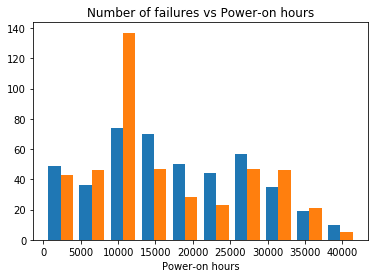

In [66]:
x=list(dfSuccess.sample(n=len(dfFailures)).smart_9_raw)
y=list(dfFailures.smart_9_raw)
plt.hist([x,y])
plt.title("Number of failures vs Power-on hours")
plt.xlabel("Power-on hours")
plt.show()

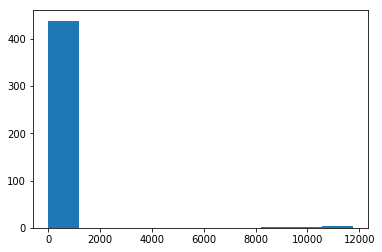

In [67]:
x=list(dfSuccess.sample(n=len(dfFailures)).smart_192_raw)
y=list(dfFailures.smart_192_raw)
plt.hist([x])
plt.show()
df_192 = dfFailures[dfFailures.smart_192_raw>10][['model','smart_192_raw']].sort_values(by = 'smart_192_raw', ascending = False)
#y=list(df_192.smart_192_raw)
#plt.scatter(x,y)
#plt.show()
#print(df_192)

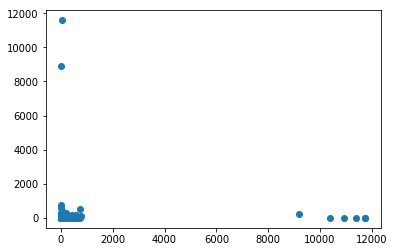

In [68]:
plt.scatter(x,y)
plt.show()

In [132]:
print(len(y_train_res))
y_res =  pd.DataFrame(y_train_res).rename(columns = {0:'fail'})
print(len(y_res), len(y_res[y_res.fail==1]),len(y_res[y_res.fail==0]) ,len(y_res[y_res.fail==1])/len(y_res[y_res.fail==0]) )

199984
199984 99992 99992 1.0


## Model

### 1. Logistic regression

In [86]:
def logisticRegression(X_train_res, y_train_res, Xtest, Ytest,file_name):
    #clfLR = LogisticRegression(penalty = 'l2', solver = 'saga',tol = 1e-6).fit(X_train_res, y_train_res)
    #clfLR = LogisticRegression(C=0.05).fit(X_train_res, y_train_res)
    clfLR = LogisticRegression().fit(X_train_res, y_train_res)


    #(penalty = 'l1', solver = 'liblinear',tol = 1e-6, max_iter = int(1e6),warm_start = True,intercept_scaling = 10000.)

    #predictions2 = clf2.predict(Xtest)

    filename = file_name +'.sav'
    pickle.dump(clfLR, open(filename, 'wb'))
    return clfLR

In [87]:
clfLR = logisticRegression(X_train_res, y_train_res, Xtest, Ytest,'finalized_model_20200215')

In [88]:
predictionsLR = clfLR.predict(Xtest)
probabilityLR = clfLR.predict_proba(Xtest)

In [89]:
print(classification_report(Ytest, predictionsLR, digits=4))
print(confusion_matrix(Ytest, predictionsLR))



              precision    recall  f1-score   support

           0     1.0000    0.4247    0.5962   9826876
           1     0.0001    0.7271    0.0001       513

    accuracy                         0.4247   9827389
   macro avg     0.5000    0.5759    0.2981   9827389
weighted avg     0.9999    0.4247    0.5961   9827389

[[4173090 5653786]
 [    140     373]]


### Validation 

In [90]:
%time    Xval,Yval = readingTestDataset("~/data/hdd_3_2019.h5",dfModels, simpleFeatures)



CPU times: user 44.2 s, sys: 29 s, total: 1min 13s
Wall time: 1min 1s


In [91]:
predictionsLR = clfLR.predict(Xval)
probabilityLR = clfLR.predict_proba(Xval)
print(classification_report(Yval, predictionsLR, digits=4))
print(confusion_matrix(Yval, predictionsLR))




              precision    recall  f1-score   support

           0     1.0000    0.4079    0.5794  10213572
           1     0.0001    0.7013    0.0001       626

    accuracy                         0.4079  10214198
   macro avg     0.5000    0.5546    0.2898  10214198
weighted avg     0.9999    0.4079    0.5794  10214198

[[4165685 6047887]
 [    187     439]]


In [96]:
#print (Xtest_user)

In [92]:
def predicProbaFromModelFile(modelFile,clfLR, Xtest, Ytest,type):
    if type =='file':
        loaded_model = pickle.load(open(modelFile, 'rb'))
    else:
        loaded_model = clfLR
    predictions = loaded_model.predict(Xtest)
    probability = loaded_model.predict_proba(Xtest)
    precision, recall, thresholds = precision_recall_curve(Ytest, probability[:,1]) 
    #retrieve probability of being 1(in second column of probs_y)
    #pr_auc = metrics.auc(recall, precision)
    return predictions, probability[:,1], recall, thresholds

predictionsLR, userProbaLR, recallLR, thresholdsLR = predicProbaFromModelFile('finalized_model_20200215.sav',clfLR,Xtest, Ytest,'')
print(classification_report(Ytest, predictionsLR,digits = 4))
print(confusion_matrix(Ytest, predictionsLR))


              precision    recall  f1-score   support

           0     1.0000    0.4247    0.5962   9826876
           1     0.0001    0.7271    0.0001       513

    accuracy                         0.4247   9827389
   macro avg     0.5000    0.5759    0.2981   9827389
weighted avg     0.9999    0.4247    0.5961   9827389

[[4173090 5653786]
 [    140     373]]


### Plotting recall vs threshold

(0, 1)

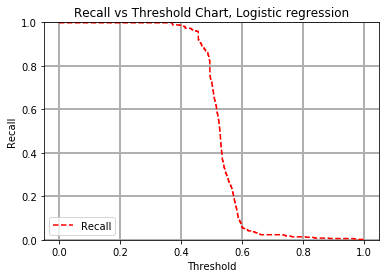

In [93]:
#precision, recall, thresholds = precision_recall_curve(Ytest, clf2.predict_proba(Xtest)[:,1]) 

plt.title("Recall vs Threshold Chart, Logistic regression")
#plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholdsLR, recallLR[: -1], "r--", label="Recall")
plt.ylabel("Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.grid(linestyle='-', linewidth=2)
plt.ylim([0,1])

#### Changing threshold

In [95]:
THRESHOLD=0.4
predictionsLR = clfLR.predict(Xtest)
predictionsLR_prob = pd.DataFrame(clfLR.predict_proba(Xtest)[:,1]).rename(columns = {0:'prob'})
prob = pd.DataFrame(predictionsLR_prob)
true = pd.DataFrame(Ytest)
pred = pd.DataFrame(predictionsLR)

all = pd.merge(true,pred, how = 'left',right_index = True,left_index = True)
all = pd.merge(all,prob, how = 'left',right_index = True,left_index = True)

#print(pd.DataFrame(predictionsLR_prob))
predictions_adj = list([1 if x > THRESHOLD else 0 for x in predictionsLR_prob['prob']])
#print(predictions_adj)
print('results after over sampling, logistic regressioin, no device filtering')

print(classification_report(Ytest, predictionsLR))
print(classification_report(Ytest, predictions_adj))
print(confusion_matrix(Ytest, predictionsLR))




results after over sampling, logistic regressioin, no device filtering
              precision    recall  f1-score   support

           0       1.00      0.42      0.60   9826876
           1       0.00      0.73      0.00       513

    accuracy                           0.42   9827389
   macro avg       0.50      0.58      0.30   9827389
weighted avg       1.00      0.42      0.60   9827389

              precision    recall  f1-score   support

           0       1.00      0.09      0.17   9826876
           1       0.00      0.99      0.00       513

    accuracy                           0.09   9827389
   macro avg       0.50      0.54      0.08   9827389
weighted avg       1.00      0.09      0.17   9827389

[[4173090 5653786]
 [    140     373]]


In [96]:
#plt.plot( predictions3, predictions3_prob, label="Precision v probability")
predProbLR = round(pd.DataFrame(predictionsLR_prob),5).rename(columns = {0: 'probability'})
predLR = pd.DataFrame(predictionsLR).rename(columns = {0: 'prediction'})
predLR = pd.merge(predLR,predProbLR, how = 'left', right_index = True, left_index=True)

In [97]:
predLR.to_csv("~/data/prediction_LogReg20200215.csv")

In [98]:
yscore = clfLR.decision_function(Xtest)


In [99]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = metrics.roc_curve(Ytest, yscore, pos_label=0)
fpr1, tpr1, thresholds1 = metrics.roc_curve(Ytest, yscore, pos_label=1)


### ROC curve

Text(0.5, 0, 'FPR')

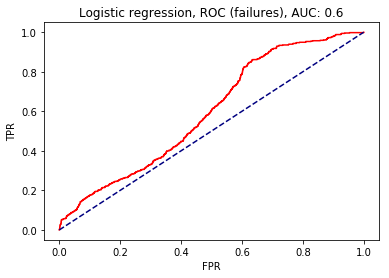

In [133]:
plt.plot(fpr1,tpr1,color='red')
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.title("Logistic regression, ROC (failures), AUC: "+ str(round(auc(fpr1,tpr1),2)))
plt.ylabel('TPR')
plt.xlabel('FPR')

### 2. Random Forests

In [104]:
def randomForest(X_train_res, y_train_res):
    #Random forests
    print('starting random forest')
    clfRF = RandomForestClassifier(max_depth=12, random_state=0,max_samples=1000,n_estimators=80).fit(X_train_res, y_train_res)
    print('feature impoartance for RF')
    print(clfRF.feature_importances_)
    pd.DataFrame(clfRF.feature_importances_).to_csv("~/data/featuresSelection.csv")
    filename = 'finalized_model_RF4.sav'
    pickle.dump(clfRF, open(filename, 'wb'))
    return clfRF

In [105]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
Xtrain_sc = sc.fit_transform(X_train_res)
Xtest_sc = sc.transform(Xtest)

In [106]:
clfRF = randomForest(X_train_res, y_train_res)

#clfRF  = pickle.load(open('finalized_model_RF2.sav', 'rb'))
predictionRF = clfRF.predict(Xtest)
probabilityRF = clfRF.predict_proba(Xtest)

print(classification_report(Ytest, predictionRF))
print(confusion_matrix(Ytest, predictionRF))

starting random forest
feature impoartance for RF
[0.03362507 0.00118337 0.03262317 0.2238008  0.01723406 0.0211833
 0.02061378 0.0229265  0.1860225  0.00723659 0.03182375 0.01878398
 0.01847865 0.02053753 0.01812737 0.03290403 0.25281039 0.01679655
 0.02328861]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98   9826876
           1       0.00      0.70      0.00       513

    accuracy                           0.97   9827389
   macro avg       0.50      0.83      0.49   9827389
weighted avg       1.00      0.97      0.98   9827389

[[9511788  315088]
 [    156     357]]


### Validation, Random Forest : #trees - 80, #max_depth - 12


In [134]:
predictionRF = clfRF.predict(Xval) 
probabilityRF = clfRF.predict_proba(Xval)
print(classification_report(Yval, predictionRF)) 
print(confusion_matrix(Yval, predictionRF))
#print(pd.DataFrame(probabilityRF))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98  10213572
           1       0.00      0.75      0.00       626

    accuracy                           0.97  10214198
   macro avg       0.50      0.86      0.49  10214198
weighted avg       1.00      0.97      0.98  10214198

[[9858227  355345]
 [    158     468]]


### Validation : userdata

In [135]:
Xtest_user,Ytest_user ,info_user = readingUserTestData("~/data/diskStat_2.csv",dfModels, simpleFeatures)

predictionRF = clfRF.predict(Xtest_user) 
probabilityRF = clfRF.predict_proba(Xtest_user)
print(classification_report(Ytest_user, predictionRF)) 
print(confusion_matrix(Ytest_user, predictionRF))
print(pd.DataFrame(probabilityRF))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
       0      1
0  0.125  0.875


In [ ]:
fprRF, tprRF, thresholdsRF = metrics.roc_curve(Ytest, probabilityRF[:,1], pos_label=1)

plt.plot(fprRF,tprRF, color='red')
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.title("ROC Random forests, failures, "+ str(round(auc(fprRF,tprRF),2)))

In [136]:
user_prob = pd.DataFrame(probabilityRF).rename(columns = {1:'probabilityRF'})
result = pd.merge(Ytest_user,user_prob[['probabilityRF']], right_index = True,left_index = True)
#print(result)

predRF = pd.DataFrame(predictionRF).rename(columns = {0:'predictions'})
result = pd.merge(result, predRF, right_index = True,left_index =True)


result = pd.merge(result, info_user[['model','capacity_bytes']], right_index = True,left_index =True)
result.to_csv("~/data/dashboardResults.csv")

#.sort_values(by ='probabilityRF', ascending=False)
#print(result)
#print(info_user)

In [139]:
featureRank = pd.read_csv("~/data/featuresSelection.csv").rename(columns={'0': 'rank'})
print(featureRank)

    Unnamed: 0      rank
0            0  0.033625
1            1  0.001183
2            2  0.032623
3            3  0.223801
4            4  0.017234
5            5  0.021183
6            6  0.020614
7            7  0.022926
8            8  0.186022
9            9  0.007237
10          10  0.031824
11          11  0.018784
12          12  0.018479
13          13  0.020538
14          14  0.018127
15          15  0.032904
16          16  0.252810
17          17  0.016797
18          18  0.023289


In [156]:
newFeatureArr=[]
for item in simpleFeatures:
    arr = item.split('_')
    if item=='capacity_bytes':
        id=0
    else:
        id =arr[1]
    newFeatureArr.append(  [id,item] )

featureDict = pd.DataFrame(newFeatureArr).rename(columns={0:'id',1:'name'})
print(featureDict)    

     id            name
0     0  capacity_bytes
1    10    smart_10_raw
2    12    smart_12_raw
3   187   smart_187_raw
4   188   smart_188_raw
5   192   smart_192_raw
6   193   smart_193_raw
7   194   smart_194_raw
8   197   smart_197_raw
9   199   smart_199_raw
10    1     smart_1_raw
11  240   smart_240_raw
12  241   smart_241_raw
13  242   smart_242_raw
14    3     smart_3_raw
15    4     smart_4_raw
16    5     smart_5_raw
17    7     smart_7_raw
18    9     smart_9_raw


In [158]:
dffeatureDict1=dffeatureDict.rename(columns={'name':'fullName'})
#print(dffeatureDict1.dtypes)
featureDict['id'] = [int(x) for x in featureDict['id']]
#print (featureDict1.head())

id           int64
fullName    object
dtype: object


In [194]:

#featureDict1
featureDict2 = pd.merge(featureDict, dffeatureDict1, how = 'left', right_on = 'id', left_on = 'id').rename(columns={'name_x':'name'})
#print(featureDict2)


In [183]:
#updating feature names for plotting
featureDict2.iloc[0, 2]=featureDict2.iloc[0, 1]
featureDict2.iloc[8, 2]='Current Pending Sector Count'


In [185]:
featureRank = pd.merge(featureDict2, featureRank, how = 'left', right_index = True, left_index = True).rename(columns = {'name_x':'name','fullName_x':'fullName'})
#print(featureRank)

In [186]:
featureRankSorted = featureRank.sort_values(by = 'rank', ascending=False)

In [188]:
top5features = featureRankSorted[['rank', 'id', 'name', 'fullName']]
#top5features.to_csv("~/data/top5Features.csv")

top5featuresArr = list(top5features['name'].head())

In [189]:
#top5features = pd.read_csv("~/data/top5Features.csv").head()[['rank','fullName']]
print(top5features.head())

        rank   id            name                       fullName
16  0.252810    5     smart_5_raw      Reallocated Sectors Count
3   0.223801  187   smart_187_raw  Reported Uncorrectable Errors
8   0.186022  197   smart_197_raw   Current Pending Sector Count
0   0.033625    0  capacity_bytes                 capacity_bytes
15  0.032904    4     smart_4_raw               Start/Stop Count


In [192]:
print(top5featuresArr)

['smart_5_raw', 'smart_187_raw', 'smart_197_raw', 'capacity_bytes', 'smart_4_raw']


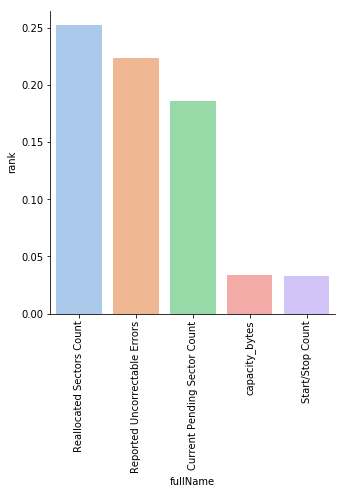

In [193]:
#plt.bar(featureRankSorted.rank,featureRankSorted.name,color='blue')
import seaborn as sns
g = sns.catplot(x="fullName", y="rank",kind = "bar", palette = "pastel",data=top5features.head());
g.set_xticklabels(rotation=90)
#plt.show()

In [136]:
#dfFailStat = dfFailures[top5featuresArr].describe()
#dfSuccessStat = dfSuccess[top5featuresArr].describe()
#dfFailStat.to_csv("~/data/failStat.csv")
#dfSuccessStat.to_csv("~/data/successStat.csv")

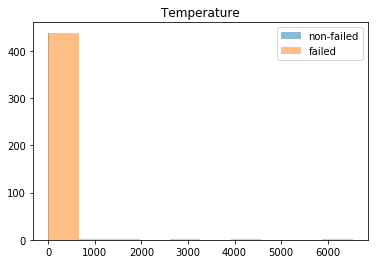

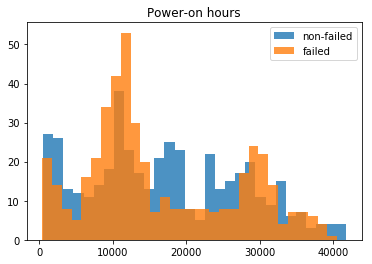

439 0
5 171


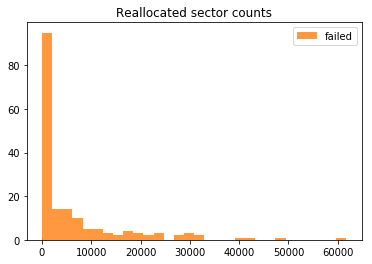

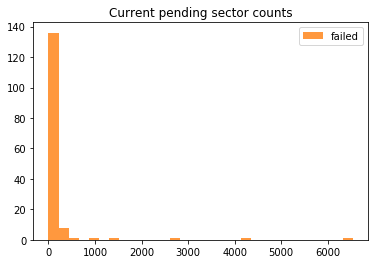

In [197]:


x=list(dfSuccess.sample(n=len(dfFailures)).smart_197_raw)
y=list(dfFailures.smart_197_raw)
#plt.hist([x, y])
plt.hist(x, alpha=0.5, label='non-failed')
plt.hist(y, alpha=0.5, label='failed')
plt.legend(loc='upper right')
plt.title('Temperature')
#plt.legend(loc='upper right')
plt.show()


x=list(dfSuccess.sample(n=len(dfFailures)).smart_9_raw)
y=list(dfFailures.smart_9_raw)
#plt.hist([x, y])
plt.hist(x, alpha=0.8, bins = 30,label='non-failed')
plt.hist(y, alpha=0.8, bins = 30,label='failed')
plt.legend(loc='upper right')
plt.title('Power-on hours')
#plt.legend(loc='upper right')
plt.show()



df_5 = dfSuccess.sample(n=len(dfFailures))
df_5s = df_5[df_5.smart_5_raw>10]
df_5fail = dfFailures[dfFailures.smart_5_raw>10]

print(len(df_5[df_5.smart_5_raw==0]), len(df_5fail[df_5fail.smart_5_raw==10]))
print(len(df_5[df_5.smart_5_raw>0]), len(df_5fail[df_5fail.smart_5_raw>0]))

#print(len(df_5[df_5.smart_5_raw<=10]), len(df_5fail[df_5fail.smart_5_raw<=10]))
#print(len(df_5[df_5.smart_5_raw>10]), len(df_5fail[df_5fail.smart_5_raw>10]))

df_5 = dfSuccess.sample(n=len(dfFailures))
df_197s = df_5[df_5.smart_197_raw>0]
df_197fail = dfFailures[dfFailures.smart_197_raw>0]


#print(df_5s['smart_5_raw'])
x=list(df_5s.smart_5_raw)
y=list(df_5fail.smart_5_raw)
#plt.hist([x, y])
plt.hist(x, alpha=0.8, bins = 30)
plt.hist(y, alpha=0.8, bins = 30,label='failed')
plt.legend(loc='upper right')
plt.title('Reallocated sector counts')
#plt.legend(loc='upper right')
plt.show()



#print(df_197s['smart_197_raw'])
x=list(df_197s.smart_197_raw)
y=list(df_197fail.smart_197_raw)
#plt.hist([x, y])
plt.hist(x, alpha=0.8, bins = 30)
plt.hist(y, alpha=0.8, bins = 30,label='failed')
plt.legend(loc='upper right')
plt.title('Current pending sector counts')
#plt.legend(loc='upper right')
plt.show()



#print(dfFailures.smart_197_raw)

#sns.distplot(x)

#plt.hist(x, alpha=0.5, label='non-failed')
#plt.hist(y, alpha=0.5, label='failed')
#plt.legend(loc='upper right')
#plt.title('Temperature')
#plt.legend(loc='upper right')
#plt.show()

In [138]:
df_197 = dfSuccess[['smart_197_raw']]
df_197fail = dfFailures[['smart_197_raw']]

In [139]:
print(len(df_197[df_197.smart_197_raw==0]), len(df_197fail[df_197fail.smart_197_raw==10]))
print(len(df_197[df_197.smart_197_raw>0]), len(df_197fail[df_197fail.smart_197_raw>0]))



99526 0
465 164


In [140]:
df_5 = dfSuccess[['smart_5_raw']]
df_5fail = dfFailures[['smart_5_raw']]
print (df_5.mean(),df_5fail.mean())
#print (df_5[['model','serial_number','smart_5_raw']])

smart_5_raw    7.644018
dtype: float64 smart_5_raw    1821.150391
dtype: float64


### Plotting confusion matrix

Confusion matrix, logistic regression
[[4173090 5653786]
 [    140     373]]


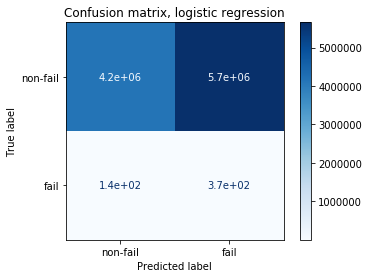

In [198]:
from sklearn.metrics import plot_confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
title = "Confusion matrix, logistic regression"
normalize = None
class_names = ['non-fail','fail']
disp = plot_confusion_matrix(clfLR, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

Confusion matrix, Random forests
[[9511788  315088]
 [    156     357]]


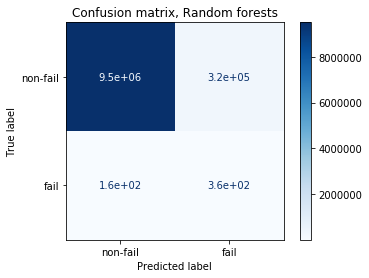

In [199]:
# Plot non-normalized confusion matrix
title = "Confusion matrix, Random forests"
normalize = None
class_names = ['non-fail','fail']
disp = plot_confusion_matrix(clfRF, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [306]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Ytest, predictions3))
print('Mean Squared Error:', metrics.mean_squared_error(Ytest, predictions3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Ytest, predictions3)))

Mean Absolute Error: 0.586439287744373
Mean Squared Error: 0.586439287744373
Root Mean Squared Error: 0.765793240858375


### Random forest with scaled features

In [307]:
clfRF = randomForest(Xtrain_sc, y_train_res)
predictionRF = clfRF.predict(Xtest_sc)
print(classification_report(Ytest, predictionRF))
print(confusion_matrix(Ytest, predictionRF))

starting random forest
feature impoartance for RF
[2.85829190e-02 2.92049709e-02 3.75768009e-01 2.25612541e-02
 4.32822187e-02 5.54890890e-02 1.33109616e-02 3.38300016e-03
 2.54386703e-02 3.52816164e-02 3.16280456e-02 1.93308197e-02
 2.76126764e-01 7.08180510e-03 3.83080357e-03 1.80362352e-05
 2.96810162e-02]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98  10213572
           1       0.00      0.75      0.00       626

    accuracy                           0.96  10214198
   macro avg       0.50      0.86      0.49  10214198
weighted avg       1.00      0.96      0.98  10214198

[[9845424  368148]
 [    157     469]]


In [84]:
#yscore = clfRF.decision_path(Xtest)


In [308]:
#dfsampleSuccess = dfSuccess.sample(n = 100000-len(dfFailures))
dfsampleSuccess = dfSuccess
  
dfsampleFailure = dfFailures


In [309]:
from sklearn.neural_network import MLPClassifier

In [310]:
from sklearn.neural_network import MLPClassifier

clfNN = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1).fit(X_train_res, y_train_res)


#MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
#              solver='lbfgs')


In [312]:
predictionsNN = clfNN.predict(Xtest)
predictionsProbNN = clfNN.predict_proba(Xtest)

In [314]:
print(classification_report(Ytest, predictionsNN))
print(confusion_matrix(Ytest, predictionsNN))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00  10213572
           1       0.00      1.00      0.00       626

    accuracy                           0.00  10214198
   macro avg       0.50      0.50      0.00  10214198
weighted avg       1.00      0.00      0.00  10214198

[[     364 10213208]
 [       0      626]]


In [114]:
dfBatch = pd.concat([dfsampleSuccess, dfsampleFailure], axis=0)
#dfBatch['modelType'] = dfBatch['modelType']
dfBatch = dstrain

In [115]:
dfBatch.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_252_normalized', 'smart_252_raw', 'smart_254_normalized',
       'smart_254_raw', 'smart_255_normalized', 'smart_255_raw', 'modelName',
       'index', 'modelType', 'modelType1'],
      dtype='object', length=133)

In [130]:
dfsampleSuccess = dfBatch[dfBatch.failure == 0]
  
dfsampleFailure = dfBatch[dfBatch.failure == 1]

In [131]:
Y = dfBatch[['failure']]

X = dfBatch[simpleFeatures]


X_train0 = X
y_train0 = Y

print("Number transactions X_train dataset: ", X_train0.shape)
print("Number transactions y_train dataset: ", y_train0.shape)


print("Current Time =", datetime.now().strftime("%H:%M:%S"))

X_train = X_train0.fillna(0)



Number transactions X_train dataset:  (100505, 17)
Number transactions y_train dataset:  (100505, 1)
Current Time = 17:18:10


In [132]:
def batchSample(dfsampleSuccess,dfsampleFailure,features):

    dfSuccessbatch = dfsampleSuccess.sample(n =100)
    dfFailurebatch = dfsampleFailure.sample(n = 100)


    dfBatch = pd.concat([dfSuccessbatch, dfFailurebatch], axis=0)

    #print(dfBatch[['failure']])


    X_batch = dfBatch[features].fillna(0)
    y_batch = dfBatch['failure']


    return X_batch,y_batch




In [133]:
def SDG(dfsampleSuccess,dfsampleFailure,features,iter):
    print(features)
    SDGmodel = linear_model.SGDClassifier(max_iter=5, tol=1e-12, loss='log',penalty='elasticnet')
    for i in range(0, iter):
        x_batch, y_batch=batchSample(dfsampleSuccess,dfsampleFailure,features)
            #print(y_batch)
        clf = SDGmodel.partial_fit(x_batch, y_batch,classes=np.unique(y_batch))
    return clf

In [134]:
#Xtest.columns
dfBatch.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized',
       'smart_2_raw', 'smart_3_normalized',
       ...
       'smart_252_normalized', 'smart_252_raw', 'smart_254_normalized',
       'smart_254_raw', 'smart_255_normalized', 'smart_255_raw', 'modelName',
       'index', 'modelType', 'modelType1'],
      dtype='object', length=133)

In [1]:
#print('Starting SGD...')
#print("Current Time =", datetime.now().strftime("%H:%M:%S"))
#simpleFeaturesHist = ['capacity_bytes','smart_1_raw', 'smart_5_raw', 'smart_7_raw','smart_9_raw', 'smart_12_raw','smart_188_raw','smart_189_raw','smart_190_raw','smart_192_raw', 'smart_194_raw', 'smart_195_raw','smart_197_raw', 'smart_199_raw','smart_200_raw', 'smart_240_raw','smart_241_raw']



#clf = SDG(dfsampleSuccess,dfsampleFailure,simpleFeatures,200)


#prediction = clf.predict(Xtest)
#print(confusion_matrix(Ytest,prediction))
#print(classification_report(Ytest, prediction, zero_division=1))

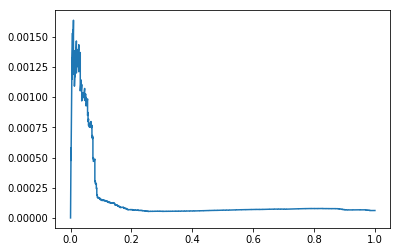

In [136]:
plt.plot( recall[: -1], precision[: -1], label="Precision v recall")

In [137]:
featureStat = (dfsampleFailure[simpleFeaturesHist] - dfsampleFailure[simpleFeaturesHist].mean()) / dfsampleFailure[simpleFeaturesHist].std()  

In [214]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

### Support vector machine

In [215]:
def runSVM(X_train_res, y_train_res):
    clf = svm.SVC().fit(X_train_res, y_train_res)
    return clf

In [216]:
clfSVM = runSVM(X_train_res, y_train_res)

In [ ]:
predictionSVM = clfSVM.predict(Xtest)

In [ ]:
print(confusion_matrix(Ytest,predictionSVM))
print(classification_report(Ytest, predictionSVM, zero_division=1))

### SVM, validation

In [ ]:
predictionSVM = clfSVM.predict(Xval)
print(confusion_matrix(Yval,predictionSVM))
print(classification_report(Yval, predictionSVM, zero_division=1))

In [ ]:
from imblearn.under_sampling import ClusterCentroids

In [17]:
def regressionUnderSampling(X, y):
    print('calculate under-sampling')

    cc = ClusterCentroids(random_state=0)
    X_resampled, y_resampled = cc.fit_resample(X, y)

    print('Results with under-sampling')
    return X_resampled, y_resampled

### Neural Network

In [203]:
from sklearn.neural_network import MLPClassifier

In [208]:
clfNN = MLPClassifier().fit(X_train_res,y_train_res)
#clf.fit(X, y)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [209]:
predictionNN = clfNN.predict(Xtest)

In [210]:
print(confusion_matrix(Ytest,predictionNN))
print(classification_report(Ytest, predictionNN))

[[1619442 8207434]
 [     66     447]]
              precision    recall  f1-score   support

           0       1.00      0.16      0.28   9826876
           1       0.00      0.87      0.00       513

    accuracy                           0.16   9827389
   macro avg       0.50      0.52      0.14   9827389
weighted avg       1.00      0.16      0.28   9827389



In [211]:
predictionNN = clfNN.predict(Xval)
print(confusion_matrix(Yval,predictionNN))
print(classification_report(Yval, predictionNN))

[[2655344 7558228]
 [    118     508]]
              precision    recall  f1-score   support

           0       1.00      0.26      0.41  10213572
           1       0.00      0.81      0.00       626

    accuracy                           0.26  10214198
   macro avg       0.50      0.54      0.21  10214198
weighted avg       1.00      0.26      0.41  10214198

